In [26]:
!pip -q install matplotlib pandas pyarrow seaborn tqdm

import matplotlib.pyplot as plt, seaborn as sns
import pandas as pd, numpy as np, json, pathlib, itertools
plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 600        # 600 dpi on-screen and in files

RES_DIR = pathlib.Path("../results")
FIG_DIR = pathlib.Path("../figures"); FIG_DIR.mkdir(exist_ok=True)

In [27]:
# daily metrics from Notebook 03
metrics = pd.read_parquet(RES_DIR/"daily_metrics.parquet").rename(columns={
    "cost_A": "Equal Thirds (A)",
    "cost_B": "One-Shot (B)",
    "cost_S": "EWMA Daily (S)",
    "cost_D": "Rolling-7 (D)"
})

# RL total from fast RL notebook
rl_total = json.load(open(RES_DIR/"rl_total.json"))["rl_total"]
metrics["RL Scheduler"] = rl_total / 180.0          # flat daily line

In [33]:
# fig, ax = plt.subplots(figsize=(8,3))
# cols = ["Equal Thirds (A)","One-Shot (B)","Rolling-7 (D)","RL Scheduler"]
# metrics.plot(x="day", y=cols, ax=ax, linewidth=0.8)
# ax.set_title("Daily Total Cost – all strategies")
# ax.set_ylabel("USD")
# ax.legend(fontsize=7)
# fig.tight_layout()
# fig.savefig(FIG_DIR/"daily_costs_lines.png", dpi=600)
# plt.show()

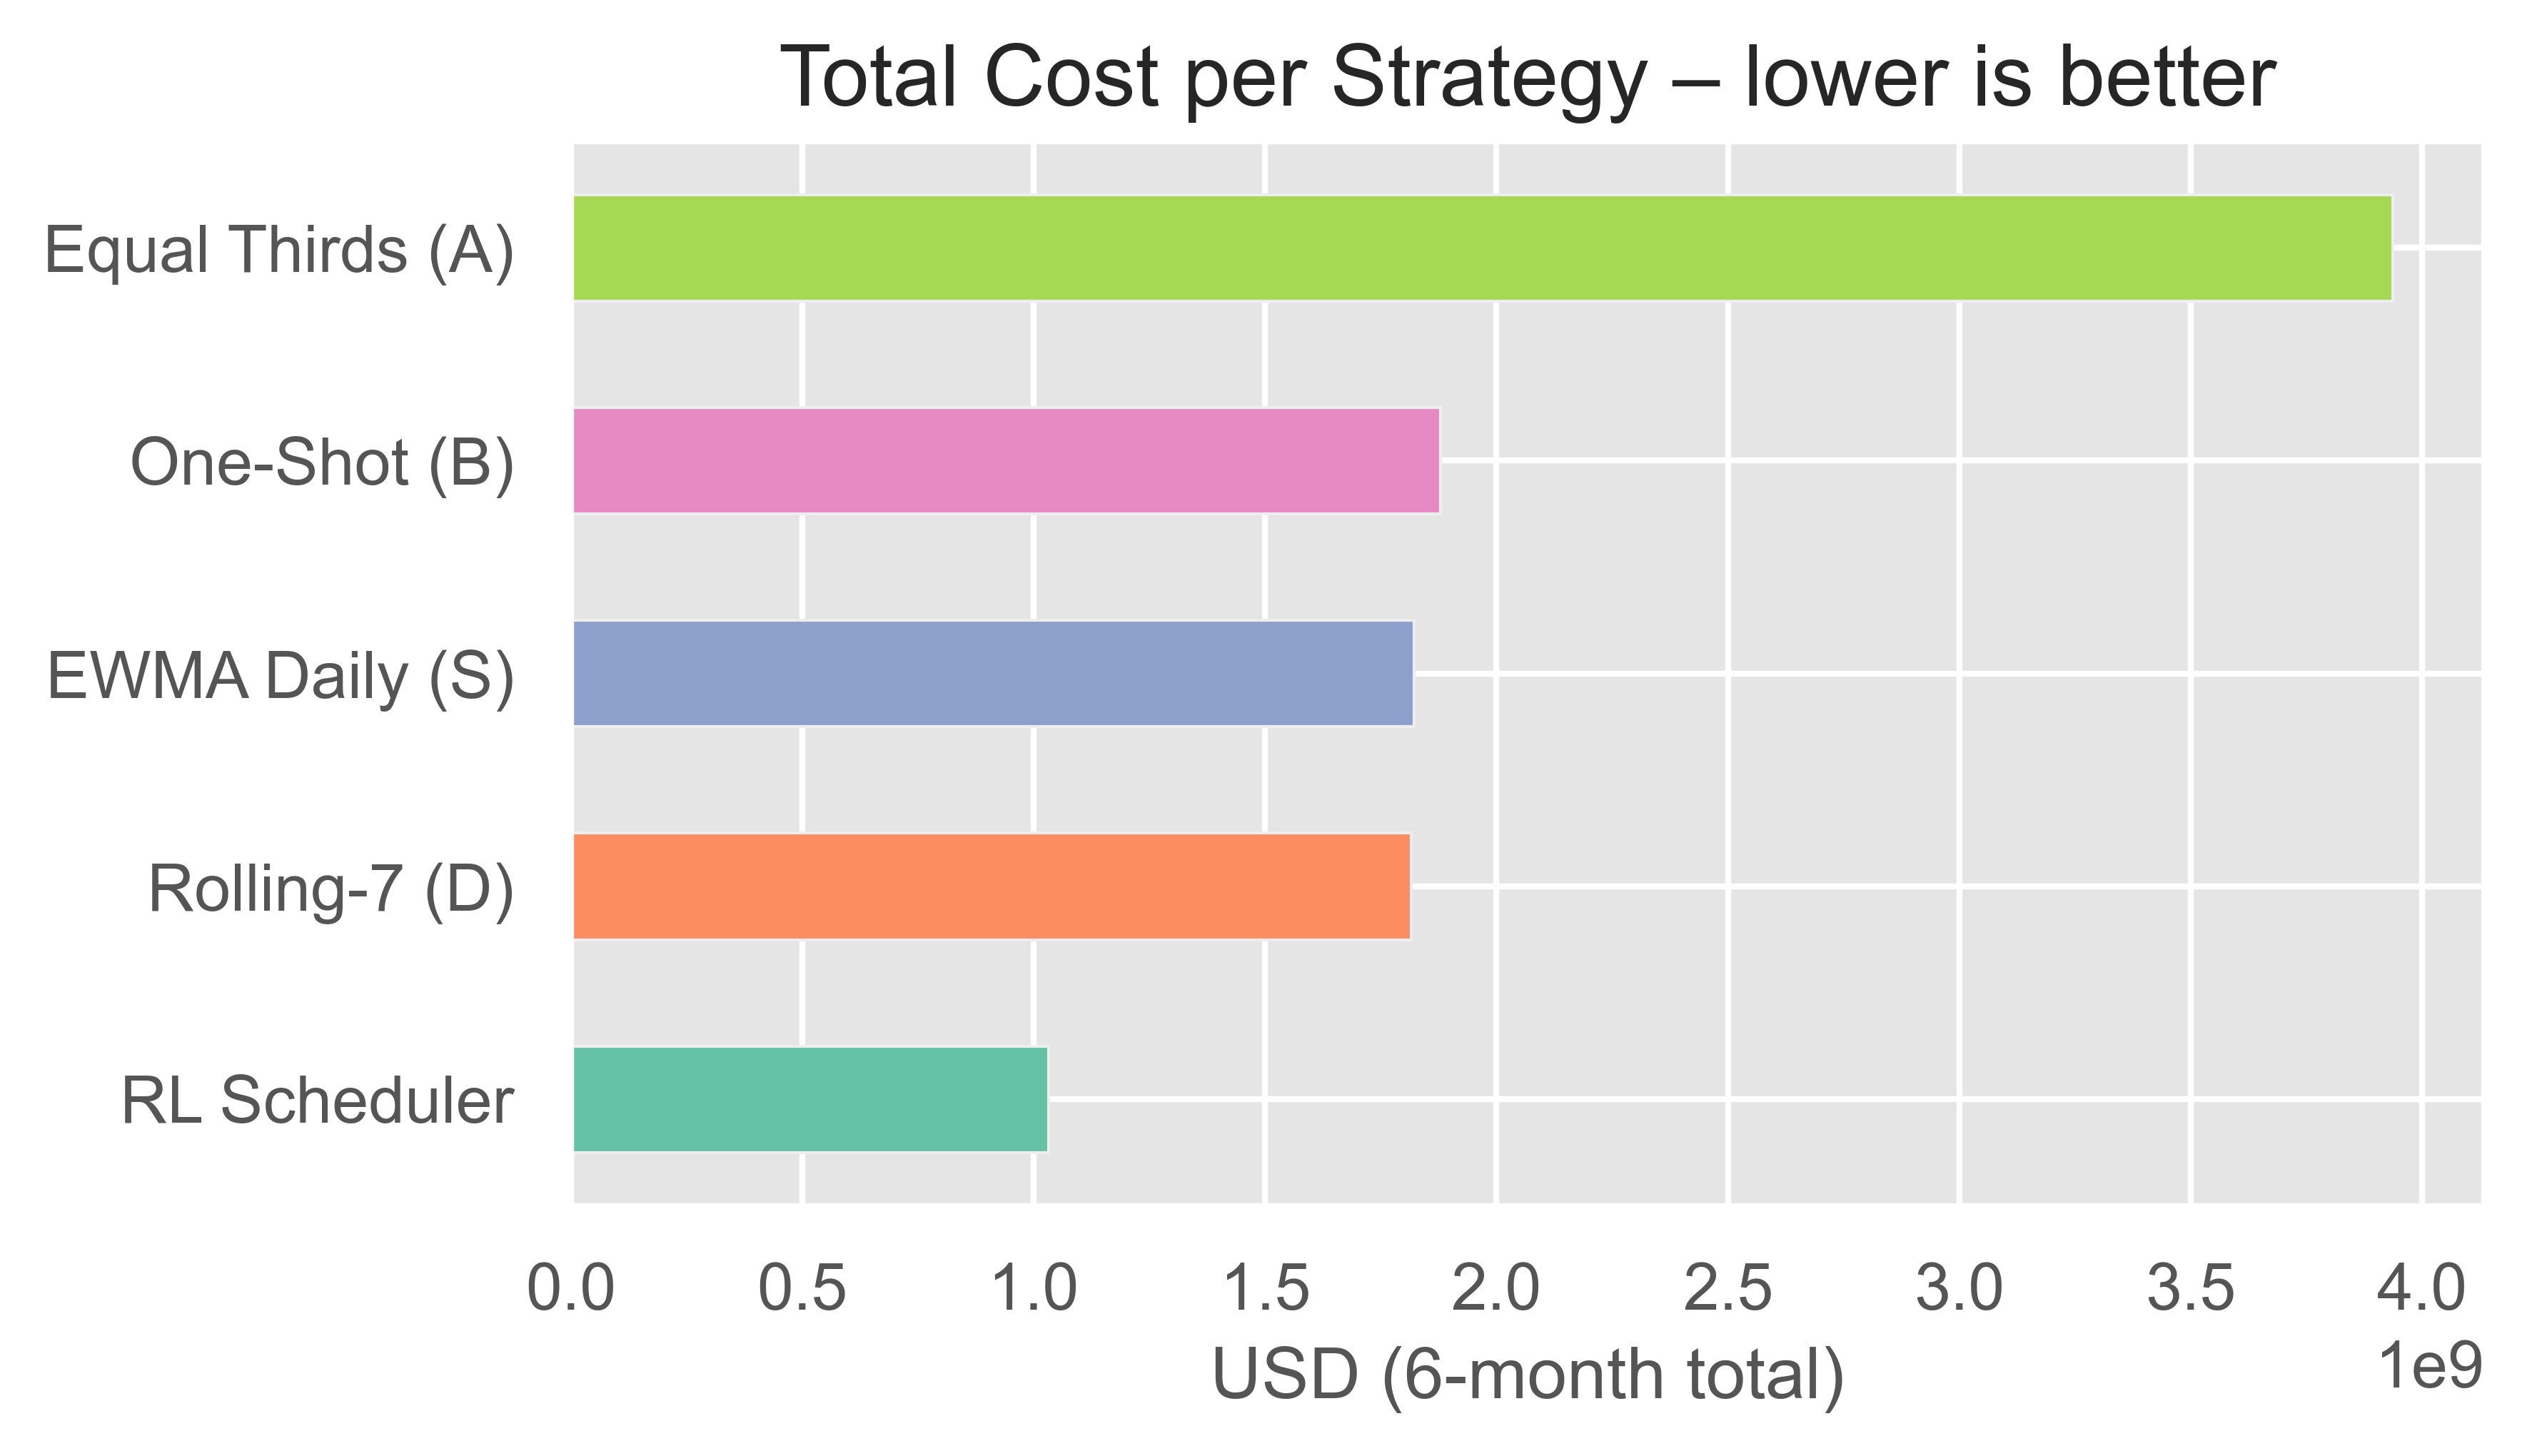

In [29]:
totals = metrics.drop(columns="day").sum().round(2)
totals = totals.sort_values()                       # ascending for barh

fig, ax = plt.subplots(figsize=(6,3.5))
totals.plot(kind="barh",
            color=sns.color_palette("Set2", len(totals)),
            ax=ax)
ax.set_xlabel("USD (6-month total)")
ax.set_title("Total Cost per Strategy – lower is better")
fig.tight_layout()
fig.savefig(FIG_DIR/"total_costs_bar.png", dpi=600)
plt.show()

/Users/tej/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


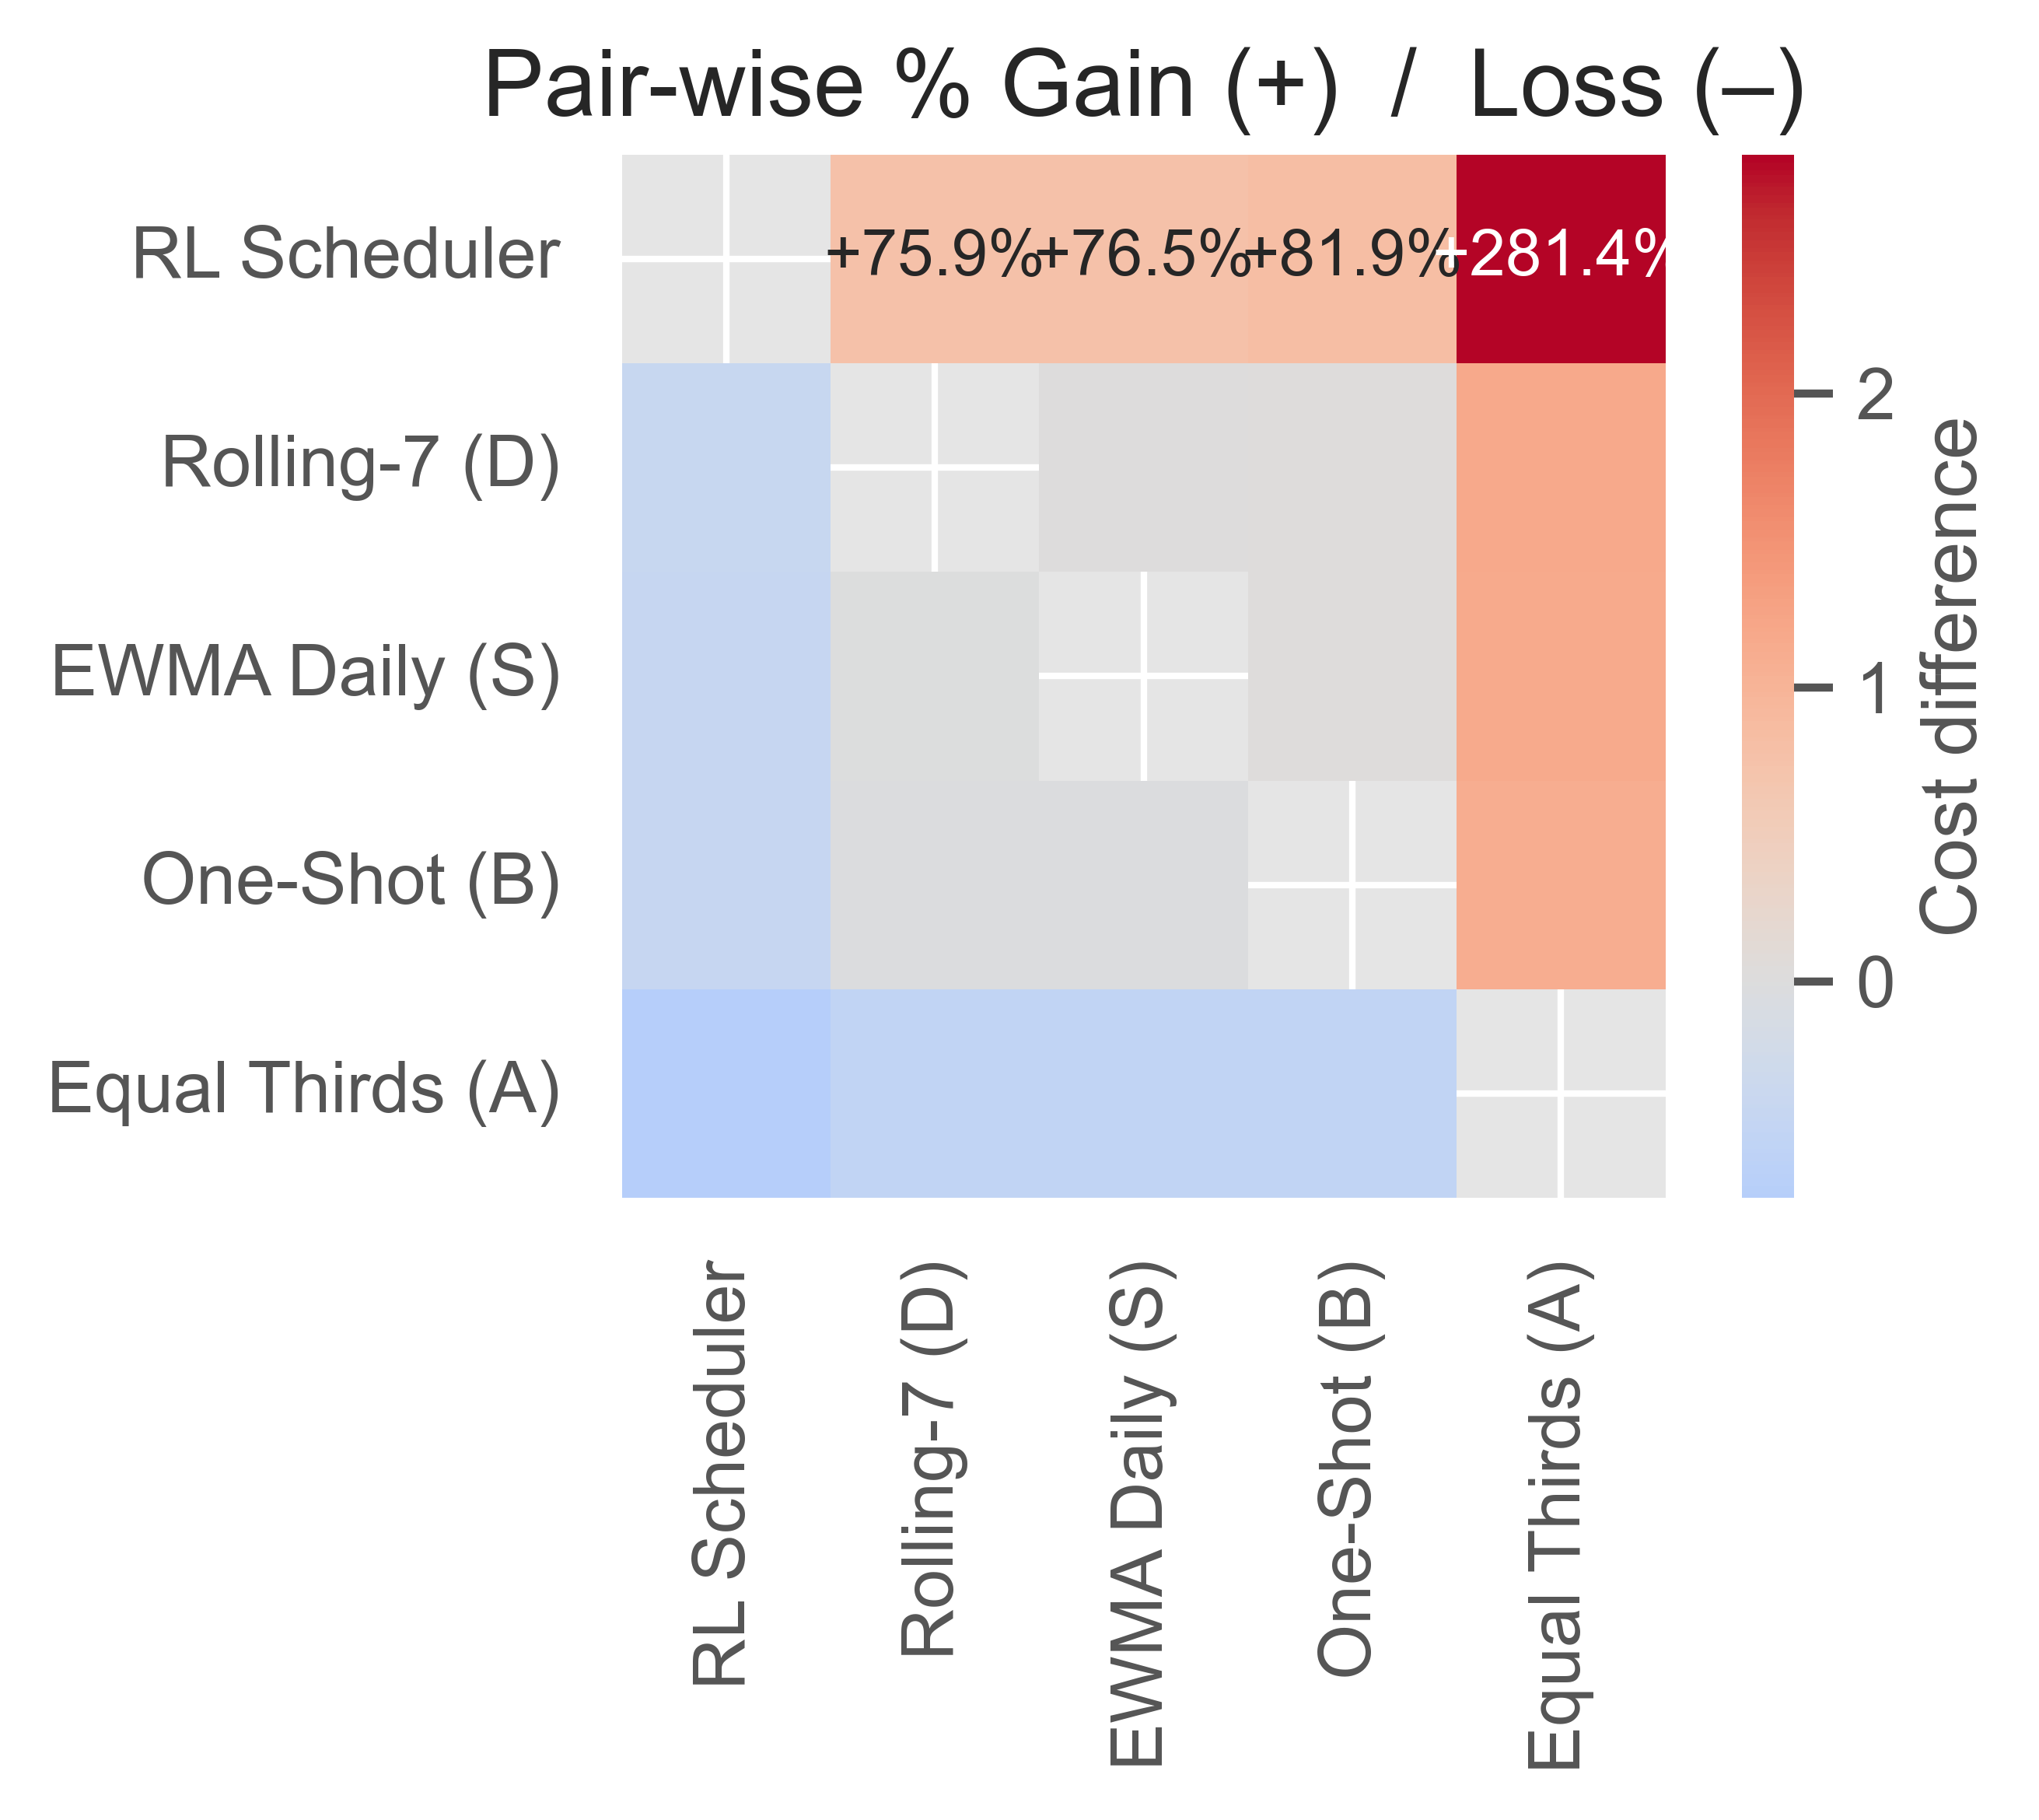

In [32]:
strategies = totals.index.tolist()
diff = pd.DataFrame(index=strategies, columns=strategies, dtype=float)

for i, j in itertools.product(strategies, strategies):
    diff.loc[i, j] = 0 if i==j else (totals[j] - totals[i]) / totals[i]

mask = np.eye(len(strategies), dtype=bool)   # hide diagonal

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(diff, annot=True, fmt="+.1%",
            cmap="coolwarm", center=0, square=True,
            mask=mask,
            cbar_kws={"label":"Cost difference"})
ax.set_title("Pair-wise % Gain (+)  /  Loss (–)")
fig.tight_layout()
fig.savefig(FIG_DIR/"pairwise_heatmap.png", dpi=600)
plt.show()

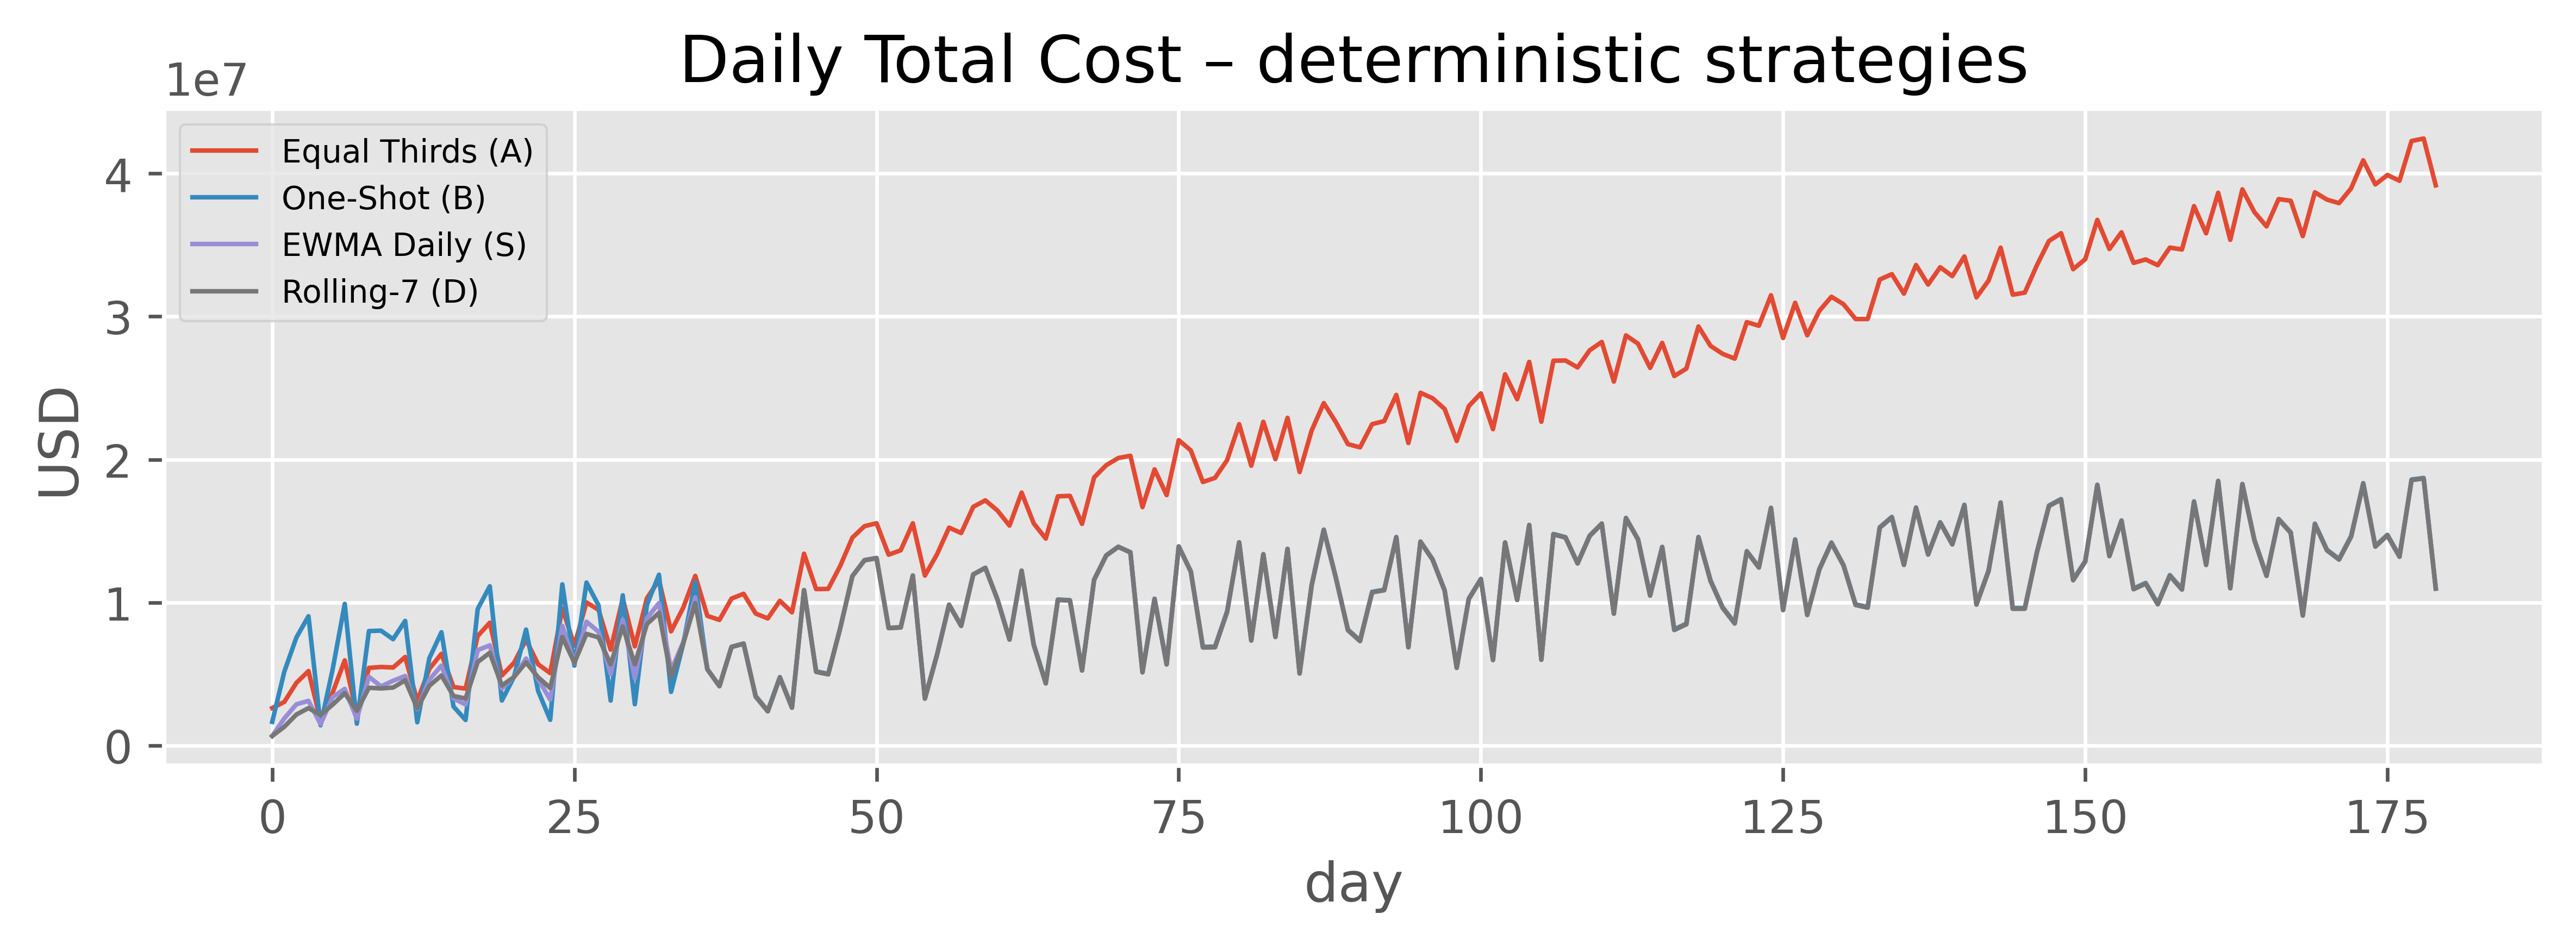

In [20]:
fig, ax = plt.subplots(figsize=(8,3))
metrics.plot(x="day",
             y=["Equal Thirds (A)",
                "One-Shot (B)",
                "EWMA Daily (S)",
                "Rolling-7 (D)"],
             ax=ax, linewidth=1.0)
ax.set_title("Daily Total Cost – deterministic strategies")
ax.set_ylabel("USD")
ax.legend(fontsize=7)
fig.tight_layout()
fig.savefig(FIG_DIR/"daily_costs_lines.png", dpi=600)
plt.show()

In [31]:
tbl = totals.to_frame("Total $").round(2)
tbl["Δ vs One-Shot B (%)"] = (tbl["Total $"]/tbl.loc["One-Shot (B)"] - 1)*100
tbl["Rank"] = tbl["Total $"].rank(method="min").astype(int)
tbl = tbl.sort_values("Rank")

display(tbl.style.format({"Total $":"${:,.2f}",
                          "Δ vs One-Shot B (%)":"{:+.1f}%"}))

tbl.to_csv(RES_DIR/"summary_table.csv")
print("✔ saved CSV →", RES_DIR/"summary_table.csv")

,Total $,Δ vs One-Shot B (%),Rank
RL Scheduler,"$1,032,365,809.11",+nan%,1
Rolling-7 (D),"$1,815,573,126.70",+nan%,2
EWMA Daily (S),"$1,822,512,061.93",+nan%,3
One-Shot (B),"$1,878,361,787.71",+nan%,4
Equal Thirds (A),"$3,937,122,560.85",+nan%,5


✔ saved CSV → ../results/summary_table.csv
